In [1]:
import json
import numpy as np
import pandas as pd

import re
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# gensim
from gensim import corpora, models, similarities, matutils
# sklearn
from sklearn import datasets
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.cluster import KMeans
from sklearn.preprocessing import normalize
from sklearn.metrics import silhouette_score
# logging for gensim (set to INFO)
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

from sklearn.metrics.pairwise import cosine_distances

import preprocessor as p # 
import string # use string.punctuation to clean out punctuation

from pprint import pprint

from datetime import datetime
import pickle



from tqdm import tqdm

pd.set_option('display.max_colwidth', -1)

In [2]:
with open("clean_tweets_sample.pkl", 'rb') as picklefile: 
    sampleDF = pickle.load(picklefile)

In [3]:
with open("clean_tweets_full.pkl", 'rb') as picklefile: 
    fullDF = pickle.load(picklefile)

## Preprocessing

In [4]:
def just_text(tweetsDF):
    cleanDF = pd.DataFrame(columns = ['id','full_text'])
    cleanDF['full_text'] = tweetsDF['full_text']
    cleanDF.drop('id',axis = 1).head()
    return cleanDF

In [5]:
sampletextDF = just_text(sampleDF)

In [6]:
fulltextDF = just_text(fullDF)

# Set Stopwords

In [7]:
from nltk.corpus import stopwords
stop = stopwords.words('english')
stop += ['climate', 'change', 'global', 'warming', 'climatechange', 'globalwarming']

## Count Vectorizer

In [8]:
def run_countvec(tweetDF):

    # Create a CountVectorizer for parsing/counting words
    count_vectorizer = CountVectorizer(ngram_range=(1, 2), #max_df = 0.8,  
                                   stop_words=stop, token_pattern="\\b[a-z][a-z]+\\b")
    count_vectorizer.fit(tweetDF.full_text)
    
    # Create the term-document matrix
    # Transpose it so the terms are the rows
    counts = count_vectorizer.transform(tweetDF.full_text).transpose()
    return count_vectorizer, counts

In [9]:
sample_count_vectorizer, sample_counts = run_countvec(sampletextDF)

In [10]:
full_count_vectorizer, full_counts = run_countvec(fulltextDF)

## TF-IDF

In [11]:
def run_tfidf(counts):
    transformer = TfidfTransformer(smooth_idf=False)
    x_tfidf = transformer.fit_transform(sample_counts)
    #xtfidf_norm = normalize(x_tfidf, norm='l1', axis=1)
    return x_tfidf

In [12]:
sample_tfidf = run_tfidf(sample_counts)

/Users/emilygeller/anaconda3/lib/python3.6/site-packages/sklearn/feature_extraction/text.py:1067: RuntimeWarning: divide by zero encountered in true_divide
  idf = np.log(float(n_samples) / df) + 1.0


In [13]:
sample_counts.shape

(51177, 17579)

In [14]:
full_tfidf = run_tfidf(full_counts)

/Users/emilygeller/anaconda3/lib/python3.6/site-packages/sklearn/feature_extraction/text.py:1067: RuntimeWarning: divide by zero encountered in true_divide
  idf = np.log(float(n_samples) / df) + 1.0


In [15]:
full_counts.shape

(73998, 180920)

In [16]:
terms = sample_count_vectorizer.get_feature_names()

In [17]:
dist = cosine_distances(sample_tfidf)

KeyboardInterrupt: 

In [17]:
def get_cluster_centers(X, labels, k_num):
    CC_list = []
    for k in range(k_num):
       # get the mean coordinates of each cluster
        CC_list.append(np.mean(X[labels == k], axis = 0))
    return CC_list

# for each cluster substract the mean from each data point to get the error
# then get the magnitude of each error, square it, and sum it

def get_SSE(X, labels):
    k_num = len(np.unique(labels))
    CC_list = get_cluster_centers(X, labels, k_num)
    CSEs = []
    for k in range(k_num):
       # for each cluster of k we get the coordinates of how far off each point is to the cluster
        error_cords = X[labels == k] - CC_list[k]
       # square the coordinates and sum to get the magnitude squared
        error_cords_sq = error_cords ** 2
        error_mag_sq = np.sum(error_cords_sq, axis = 1)
       # since we already have the magnitude of the error squared we can just take the sum for the cluster
        CSE = np.sum(error_mag_sq)
        CSEs.append(CSE)
   # sum each cluster's sum of squared errors
    return sum(CSEs)

In [18]:


SSEs = []
Sil_coefs = []

for k in tqdm(range(2,20)):
    km = KMeans(n_clusters=k, random_state=1, init='k-means++')
    km.fit(sample_tfidf.T)
    labels = km.labels_
    Sil_coefs.append(silhouette_score(sample_tfidf.T,labels, metric='euclidean'))
    #SSEs.append(get_SSE(sample_tfidf.T, labels)) # The SSE is just inertia, we
                                           # could have just said km.inertia_
    SSEs.append(km.inertia_)

100%|██████████| 18/18 [15:52<00:00, 52.90s/it]


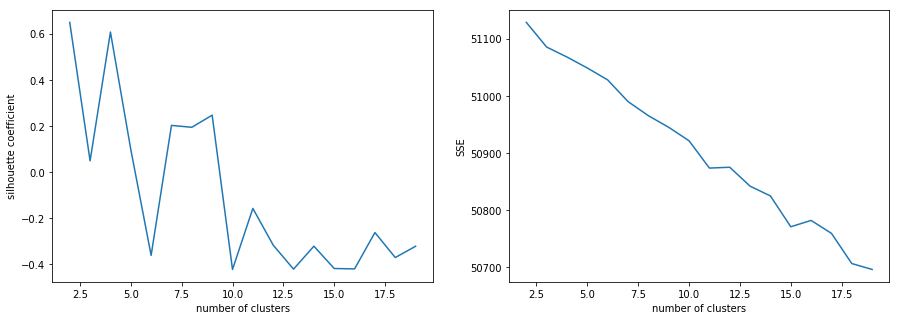

In [21]:
# number of clusters for kmeans
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,5), sharex=True)
k_clusters = range(2,20)
ax1.plot(k_clusters, Sil_coefs)
ax1.set_xlabel('number of clusters')
ax1.set_ylabel('silhouette coefficient')

# Sum of Square Error
ax2.plot(k_clusters, SSEs)
ax2.set_xlabel('number of clusters')
ax2.set_ylabel('SSE')
plt.show();

In [ ]:
km = KMeans(n_clusters=9, random_state=1, init='k-means++')
km.fit(sample_tfidf.T)

In [44]:
sample_tfidf.shape

(51177, 17579)

In [45]:
len(clusters)

17579

In [46]:
sampletextDF['cluster'] = clusters

In [47]:
sampletextDF.cluster.value_counts()

0    17562
1    16   
2    1    
Name: cluster, dtype: int64

In [24]:
print("Top terms per cluster:")
print()
#sort cluster centers by proximity to centroid
order_centroids = km.cluster_centers_.argsort()[:, ::-1] 

for i in range(10):
    print("Cluster %d words:" % i, end='')
    
    for ind in order_centroids[i, :6]: #replace 6 with n words per cluster
        print(' %s' % terms[ind], end=',')
    print() #add whitespace
    print() #add whitespace
    

    print() #add whitespace
    print() #add whitespace
    
print()
print()

Top terms per cluster:

Cluster 0 words: additional deaths, thousands additional, occur held, said tens, letter cited, epa study,



Cluster 1 words: degrees mean, australians really, runaway knows, want responsible, greenhouse emissions, minister unchecked,



Cluster 2 words: world, trees, arctic, new, million, changed,



Cluster 3 words: involvement paris, slush, fund world, palestine knows, palestine, un phony,



Cluster 4 words: detailed plan, entirely renewables, city created, solar projects, created detailed, carbonfootprint yr,



Cluster 5 words: old baby, real universal, gap real, free speech, socialism diff, ar gender,



Cluster 6 words: colonisation linked, hold unique, people lost, home thousands, settlement colonisation, settlement,



Cluster 7 words: confusion general, temp also, direct reason, reason high, main reason, general direct,



Cluster 8 words: ice reforming, reforming denial, property morningjoe, morningjoe, hope ignorant, ignorant republicans,



Cluster

In [ ]:
from scipy.cluster.hierarchy import ward, dendrogram, linkage

linkage_matrix = ward(dist) #define the linkage_matrix using ward clustering pre-computed distances

fig, ax = plt.subplots(figsize=(15, 20)) # set size
ax = dendrogram(linkage_matrix, orientation="right", labels=titles);

plt.tick_params(\
    axis= 'x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom='off',      # ticks along the bottom edge are off
    top='off',         # ticks along the top edge are off
    labelbottom='off')

plt.tight_layout() #show plot with tight layout

#uncomment below to save figure
plt.savefig('ward_clusters.png', dpi=200) #save figure as ward_clusters

In [25]:
from scipy.cluster.hierarchy import ward, dendrogram, linkage

In [26]:
X = linkage(sample_tfidf, 'ward')

ValueError: setting an array element with a sequence.